In [2]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from lightgbm import plot_importance, plot_metric

from sklearn.metrics import accuracy_score, make_scorer
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Normalizer, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders import CatBoostEncoder, OrdinalEncoder

import warnings
warnings.simplefilter("ignore")
from datetime import datetime

# onevsAll???

In [4]:
# import all data
values = pd.read_csv(
    '../data/raw/training set values.csv', 
    index_col='id', 
    parse_dates=['date_recorded'], 
    infer_datetime_format=True
)

labels = pd.read_csv(
    '../data/raw/training set labels.csv',
    index_col='id'
    
)
data = values.join(labels)

In [6]:
# import holdout data
datatest = pd.read_csv(
    '../data/raw/test set values.csv', 
   index_col='id', 
   parse_dates=['date_recorded'], 
   infer_datetime_format=True
)

## Data Preparation

In [7]:
# predict label
y = data.status_group

# all features
X = data.drop('status_group', axis=1)

In [8]:
# encode target as int's
y_transformer = LabelEncoder()
y = y_transformer.fit_transform(y)

In [9]:
# select numeric columns,
# TODO: Normalize or Scale (geoposition data? (lat, long))
NUMERIC_COLUMNS = X.select_dtypes(include=['number']).columns

In [10]:
# select categorical columns
TEXT_COLUMNS = X.select_dtypes(include=['object']).columns
X[TEXT_COLUMNS] = X[TEXT_COLUMNS].astype(str)

In [11]:
DATE_COLUMNS=['date_recorded_day', 'date_recorded_month', 'date_recorded_year']

In [12]:
# define transformers for develop a sklearn-pipeline
get_numeric_data = FunctionTransformer(lambda df: df[NUMERIC_COLUMNS])
get_text_data = FunctionTransformer(lambda df: df[TEXT_COLUMNS])
get_date_data = FunctionTransformer(lambda df: df[['date_recorded']])

transform_date_data = FunctionTransformer(lambda df: df.assign(
    date_recorded_day=df.date_recorded.dt.day,
    date_recorded_month=df.date_recorded.dt.month,
    date_recorded_year=df.date_recorded.dt.year
).drop('date_recorded', axis=1))

fill_empty_data = FunctionTransformer(lambda df: df.fillna('mean', axis=1)) # may be a SimpleImputer

In [13]:
# TODO: stratified by categorical features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    stratify=y
)

In [14]:

feature_pipeline = FeatureUnion(
            transformer_list = [
                ('date_features', Pipeline([
                    ('selector', get_date_data),
                    ('transform', transform_date_data)
                ])),
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer()),
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('imputer', fill_empty_data),
                    ('vectorizer', OrdinalEncoder())
                    #('decomposition', TruncatedSVD(n_components=50))
                ]))
             ]
        )

In [15]:
# preprocess X_train and X_test separately, avoiding data-leakage
fp = feature_pipeline.fit(X_train, y_train)

In [16]:
X_train_preprocess = pd.DataFrame(
    fp.transform(X_train), 
    columns=list(DATE_COLUMNS) + list(NUMERIC_COLUMNS) + list(TEXT_COLUMNS)
)

X_test_preprocess = pd.DataFrame(
    fp.transform(X_test), 
    columns=list(DATE_COLUMNS) + list(NUMERIC_COLUMNS) + list(TEXT_COLUMNS)
)

In [17]:
# preprocess all data. Train transformers in whole dataset
fp_all = feature_pipeline.fit(X)

In [18]:
X_prepro = fp_all.transform(X)
datatest_prepro = fp_all.transform(datatest)

### Hyperparameter tuning

In [19]:
# other scikit-learn modules
estimator = LGBMClassifier(
    silent=True,
)

param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [300,800],
    'subsample': [0.7],
    'num_leaves': [40],
#     'max_depth': [15],
    'colsample_bytree': [0.7],
}

param_fit_grid={
    'eval_set': [(X_test_preprocess, y_test)],
    'verbose':False,
    'early_stopping_rounds':5
}

gbm = GridSearchCV(
    estimator, 
    param_grid, 
    scoring= {'accuracy': make_scorer(accuracy_score)}, 
    cv=3, 
    return_train_score=True, 
    refit='accuracy'
)

gbm.fit(
    X_train_preprocess, 
    y_train, 
    **param_fit_grid, 
    categorical_feature=list(TEXT_COLUMNS)
)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                  

In [20]:
# test other parameters
gbm.best_params_, gbm.best_score_

({'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'n_estimators': 300,
  'num_leaves': 40,
  'subsample': 0.7},
 0.7891351324187145)

In [21]:
# TODO: see overfit (.85 train vs 0.79 test)
gbm.cv_results_['mean_test_accuracy'], gbm.cv_results_['mean_train_accuracy']

(array([0.78913513, 0.78913513]), array([0.85029398, 0.85029398]))

### Train LGB model

In [22]:
model_lgb = LGBMClassifier(
   **gbm.best_params_,
    silent=True
)


history = model_lgb.fit(
    X_train_preprocess, y_train, 
    eval_set= [(X_train_preprocess, y_train), (X_test_preprocess, y_test)],
    verbose=False,
    early_stopping_rounds=10,
    categorical_feature=list(TEXT_COLUMNS),
)

### Test LGB model

In [23]:
accuracy_score(model_lgb.predict(X_train_preprocess, num_iteration=model_lgb.best_iteration_), y_train)

0.8598924569073823

In [24]:
accuracy_score(model_lgb.predict(X_test_preprocess, num_iteration=model_lgb.best_iteration_), y_test)

0.7949699010305071

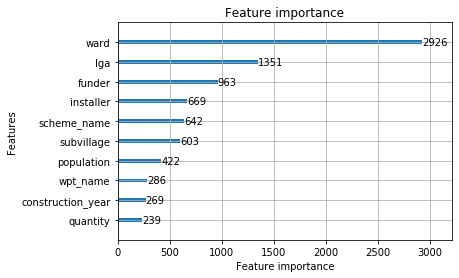

In [25]:
plot_importance(model_lgb, max_num_features=10)

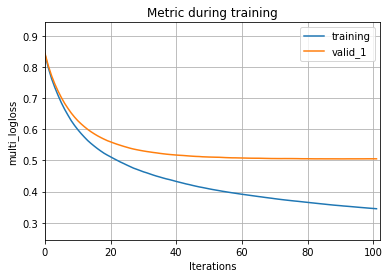

In [26]:
# almost overfitted :( )
plot_metric(model_lgb.evals_result_)

### LGB for final prediction (deployment)

In [27]:
final_lgb =  LGBMClassifier(
   **gbm.best_params_,
    silent=True
)

final_lgb.fit(
    X_prepro, y
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=40, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [28]:
accuracy_score(final_lgb.predict(X_prepro, num_iteration=final_lgb.best_iteration_), y)

0.8564141414141414

In [29]:
predictions = final_lgb.predict(datatest_prepro)
predictions = y_transformer.inverse_transform(predictions)

In [30]:
# export data for submition
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv(f'../data/results/results-lgb-{now_str}.csv')